# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Tensor

### Reverse-mode autodiff

In [2]:
x = Tensor(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

[[45.]]
[[62.]]


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ data {n.data} | grad {n.grad} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

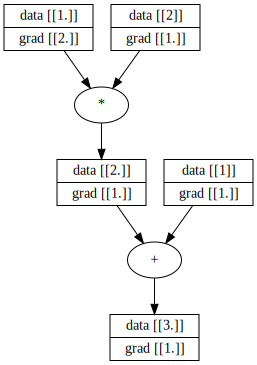

In [4]:
x = Tensor(1.0)
y = (x * 2 + 1)
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2, activation='sigmoid')
print(n)
print(n.parameters())

<function sigmoid at 0x7f6974b434c0> Neuron(2)
[Tensor(data=[[0.01524772]
 [0.04008171]], grad=[[0.]
 [0.]]), Tensor(data=[[-0.4550473]], grad=[[0.]])]


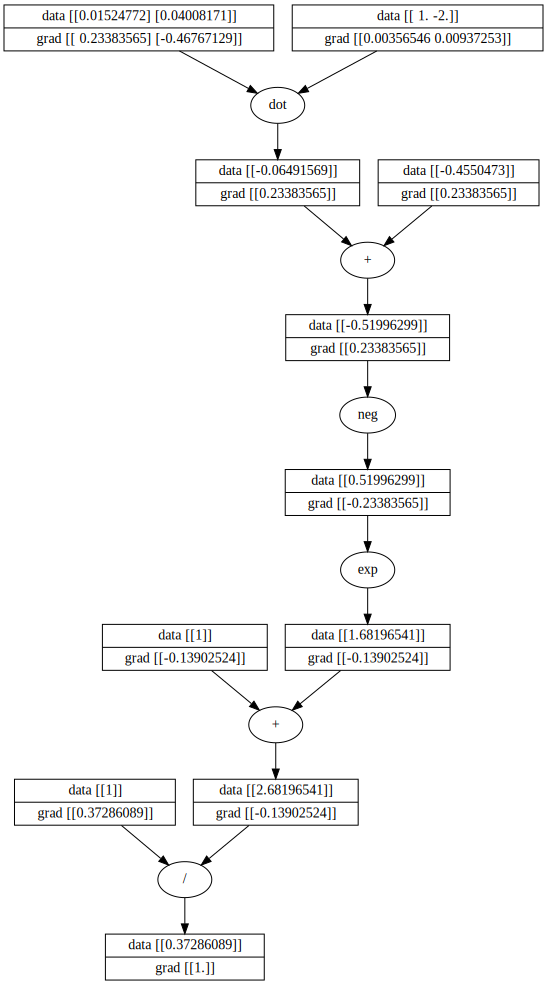

In [6]:
n.zero_grad()
x = Tensor([1.0, -2.0])
y = n(x)
y.backward()
draw_dot(y)

### Learning a line: y = 2 * x + 1

In [7]:
from pyfit.engine import Tensor
from pyfit.nn import Sequential, Dense
from pyfit.optim import SGD
from pyfit.loss import mean_squared_error
from pyfit.train import Trainer
from pyfit.data import BatchIterator

inputs = Tensor([[x] for x in range(10)])
targets = Tensor([[2*x+1] for x in range(10)])

n = Neuron(1, activation='linear')
optimizer = SGD(n.parameters(), learning_rate=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(10):
        output = n(inputs[i])
        loss = mean_squared_error(output, targets[i])
        epoch_loss += loss.data[0, 0]
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {epoch_loss}, w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")
print(f"w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")

epoch: 0, loss: 502.81765388444774, w: 0.8542905541077632, b: 2.5246546849654363
epoch: 10, loss: 0.11093077668870797, w: 1.9698875986700746, b: 1.1112029666789125
epoch: 20, loss: 0.0001877655366959686, w: 1.9987611921961739, b: 1.0045749688439973
epoch: 30, loss: 3.1779561637225307e-07, w: 1.999949035244918, b: 1.0001882149645311
epoch: 40, loss: 5.37873218486862e-10, w: 1.9999979033016637, b: 1.00000774319434
epoch: 50, loss: 9.103574262659219e-13, w: 1.9999999137414881, b: 1.0000003185562787
epoch: 60, loss: 1.5407917905637019e-15, w: 1.9999999964513107, b: 1.0000000131054578
epoch: 70, loss: 2.6078005413984526e-18, w: 1.9999999998540066, b: 1.0000000005391605
epoch: 80, loss: 4.4136298136826346e-21, w: 1.9999999999939944, b: 1.0000000000221816
epoch: 90, loss: 7.462236487559662e-24, w: 1.9999999999997526, b: 1.0000000000009122
w: 1.9999999999999856, b: 1.0000000000000528


### Learning XOR

In [8]:
inputs = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = Tensor([[0], [1], [1], [0]])

print(inputs.shape)
print(targets.shape)

(4, 2)
(4, 1)


In [9]:
model = Sequential()
model.add(Dense(2, 4, activation='sigmoid'))
model.add(Dense(4, 1, activation='sigmoid'))
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of <function sigmoid at 0x7f6974b434c0> Neurons(2), Layer of <function sigmoid at 0x7f6974b434c0> Neurons(4)]
Number of parameters: 4


In [10]:
optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = mean_squared_error
batch = BatchIterator(inputs, targets, batch_size=4, shuffle=True)

trainer = Trainer(model, optimizer, loss)
_ = trainer.fit(batch, num_epochs=10000, verbose=True)

model(inputs)

Epoch [1/10000], loss: 0.253950, accuracy: 50.00%
Epoch [11/10000], loss: 0.252162, accuracy: 50.00%
Epoch [21/10000], loss: 0.251090, accuracy: 50.00%
Epoch [31/10000], loss: 0.250448, accuracy: 50.00%
Epoch [41/10000], loss: 0.250060, accuracy: 50.00%
Epoch [51/10000], loss: 0.249823, accuracy: 50.00%
Epoch [61/10000], loss: 0.249673, accuracy: 75.00%
Epoch [71/10000], loss: 0.249573, accuracy: 75.00%
Epoch [81/10000], loss: 0.249503, accuracy: 75.00%
Epoch [91/10000], loss: 0.249451, accuracy: 75.00%
Epoch [101/10000], loss: 0.249408, accuracy: 75.00%
Epoch [111/10000], loss: 0.249370, accuracy: 75.00%
Epoch [121/10000], loss: 0.249336, accuracy: 75.00%
Epoch [131/10000], loss: 0.249304, accuracy: 75.00%
Epoch [141/10000], loss: 0.249273, accuracy: 75.00%
Epoch [151/10000], loss: 0.249242, accuracy: 75.00%
Epoch [161/10000], loss: 0.249212, accuracy: 75.00%
Epoch [171/10000], loss: 0.249182, accuracy: 75.00%
Epoch [181/10000], loss: 0.249152, accuracy: 75.00%
Epoch [191/10000], loss

Epoch [1631/10000], loss: 0.240976, accuracy: 50.00%
Epoch [1641/10000], loss: 0.240866, accuracy: 50.00%
Epoch [1651/10000], loss: 0.240754, accuracy: 50.00%
Epoch [1661/10000], loss: 0.240641, accuracy: 50.00%
Epoch [1671/10000], loss: 0.240527, accuracy: 50.00%
Epoch [1681/10000], loss: 0.240412, accuracy: 50.00%
Epoch [1691/10000], loss: 0.240295, accuracy: 50.00%
Epoch [1701/10000], loss: 0.240177, accuracy: 50.00%
Epoch [1711/10000], loss: 0.240057, accuracy: 50.00%
Epoch [1721/10000], loss: 0.239937, accuracy: 50.00%
Epoch [1731/10000], loss: 0.239814, accuracy: 50.00%
Epoch [1741/10000], loss: 0.239691, accuracy: 50.00%
Epoch [1751/10000], loss: 0.239566, accuracy: 50.00%
Epoch [1761/10000], loss: 0.239440, accuracy: 50.00%
Epoch [1771/10000], loss: 0.239312, accuracy: 50.00%
Epoch [1781/10000], loss: 0.239183, accuracy: 50.00%
Epoch [1791/10000], loss: 0.239053, accuracy: 50.00%
Epoch [1801/10000], loss: 0.238921, accuracy: 50.00%
Epoch [1811/10000], loss: 0.238788, accuracy: 

Epoch [3301/10000], loss: 0.199398, accuracy: 50.00%
Epoch [3311/10000], loss: 0.199038, accuracy: 50.00%
Epoch [3321/10000], loss: 0.198678, accuracy: 50.00%
Epoch [3331/10000], loss: 0.198318, accuracy: 50.00%
Epoch [3341/10000], loss: 0.197958, accuracy: 50.00%
Epoch [3351/10000], loss: 0.197598, accuracy: 50.00%
Epoch [3361/10000], loss: 0.197238, accuracy: 50.00%
Epoch [3371/10000], loss: 0.196879, accuracy: 50.00%
Epoch [3381/10000], loss: 0.196520, accuracy: 50.00%
Epoch [3391/10000], loss: 0.196161, accuracy: 50.00%
Epoch [3401/10000], loss: 0.195803, accuracy: 50.00%
Epoch [3411/10000], loss: 0.195445, accuracy: 50.00%
Epoch [3421/10000], loss: 0.195087, accuracy: 50.00%
Epoch [3431/10000], loss: 0.194730, accuracy: 50.00%
Epoch [3441/10000], loss: 0.194374, accuracy: 50.00%
Epoch [3451/10000], loss: 0.194018, accuracy: 50.00%
Epoch [3461/10000], loss: 0.193663, accuracy: 50.00%
Epoch [3471/10000], loss: 0.193308, accuracy: 50.00%
Epoch [3481/10000], loss: 0.192954, accuracy: 

Epoch [4901/10000], loss: 0.155654, accuracy: 50.00%
Epoch [4911/10000], loss: 0.155481, accuracy: 50.00%
Epoch [4921/10000], loss: 0.155309, accuracy: 50.00%
Epoch [4931/10000], loss: 0.155139, accuracy: 50.00%
Epoch [4941/10000], loss: 0.154969, accuracy: 50.00%
Epoch [4951/10000], loss: 0.154800, accuracy: 50.00%
Epoch [4961/10000], loss: 0.154631, accuracy: 50.00%
Epoch [4971/10000], loss: 0.154464, accuracy: 50.00%
Epoch [4981/10000], loss: 0.154297, accuracy: 50.00%
Epoch [4991/10000], loss: 0.154131, accuracy: 50.00%
Epoch [5001/10000], loss: 0.153966, accuracy: 50.00%
Epoch [5011/10000], loss: 0.153801, accuracy: 50.00%
Epoch [5021/10000], loss: 0.153638, accuracy: 50.00%
Epoch [5031/10000], loss: 0.153475, accuracy: 50.00%
Epoch [5041/10000], loss: 0.153312, accuracy: 50.00%
Epoch [5051/10000], loss: 0.153151, accuracy: 50.00%
Epoch [5061/10000], loss: 0.152990, accuracy: 50.00%
Epoch [5071/10000], loss: 0.152830, accuracy: 50.00%
Epoch [5081/10000], loss: 0.152670, accuracy: 

Epoch [6511/10000], loss: 0.125908, accuracy: 100.00%
Epoch [6521/10000], loss: 0.125549, accuracy: 100.00%
Epoch [6531/10000], loss: 0.125183, accuracy: 100.00%
Epoch [6541/10000], loss: 0.124812, accuracy: 100.00%
Epoch [6551/10000], loss: 0.124435, accuracy: 100.00%
Epoch [6561/10000], loss: 0.124051, accuracy: 100.00%
Epoch [6571/10000], loss: 0.123662, accuracy: 100.00%
Epoch [6581/10000], loss: 0.123266, accuracy: 100.00%
Epoch [6591/10000], loss: 0.122864, accuracy: 100.00%
Epoch [6601/10000], loss: 0.122456, accuracy: 100.00%
Epoch [6611/10000], loss: 0.122041, accuracy: 100.00%
Epoch [6621/10000], loss: 0.121620, accuracy: 100.00%
Epoch [6631/10000], loss: 0.121192, accuracy: 100.00%
Epoch [6641/10000], loss: 0.120758, accuracy: 100.00%
Epoch [6651/10000], loss: 0.120317, accuracy: 100.00%
Epoch [6661/10000], loss: 0.119870, accuracy: 100.00%
Epoch [6671/10000], loss: 0.119416, accuracy: 100.00%
Epoch [6681/10000], loss: 0.118955, accuracy: 100.00%
Epoch [6691/10000], loss: 0.

Epoch [8061/10000], loss: 0.043890, accuracy: 100.00%
Epoch [8071/10000], loss: 0.043553, accuracy: 100.00%
Epoch [8081/10000], loss: 0.043219, accuracy: 100.00%
Epoch [8091/10000], loss: 0.042889, accuracy: 100.00%
Epoch [8101/10000], loss: 0.042563, accuracy: 100.00%
Epoch [8111/10000], loss: 0.042240, accuracy: 100.00%
Epoch [8121/10000], loss: 0.041920, accuracy: 100.00%
Epoch [8131/10000], loss: 0.041604, accuracy: 100.00%
Epoch [8141/10000], loss: 0.041291, accuracy: 100.00%
Epoch [8151/10000], loss: 0.040981, accuracy: 100.00%
Epoch [8161/10000], loss: 0.040674, accuracy: 100.00%
Epoch [8171/10000], loss: 0.040371, accuracy: 100.00%
Epoch [8181/10000], loss: 0.040071, accuracy: 100.00%
Epoch [8191/10000], loss: 0.039774, accuracy: 100.00%
Epoch [8201/10000], loss: 0.039480, accuracy: 100.00%
Epoch [8211/10000], loss: 0.039189, accuracy: 100.00%
Epoch [8221/10000], loss: 0.038901, accuracy: 100.00%
Epoch [8231/10000], loss: 0.038616, accuracy: 100.00%
Epoch [8241/10000], loss: 0.

Epoch [9641/10000], loss: 0.016875, accuracy: 100.00%
Epoch [9651/10000], loss: 0.016797, accuracy: 100.00%
Epoch [9661/10000], loss: 0.016719, accuracy: 100.00%
Epoch [9671/10000], loss: 0.016643, accuracy: 100.00%
Epoch [9681/10000], loss: 0.016567, accuracy: 100.00%
Epoch [9691/10000], loss: 0.016491, accuracy: 100.00%
Epoch [9701/10000], loss: 0.016416, accuracy: 100.00%
Epoch [9711/10000], loss: 0.016342, accuracy: 100.00%
Epoch [9721/10000], loss: 0.016268, accuracy: 100.00%
Epoch [9731/10000], loss: 0.016194, accuracy: 100.00%
Epoch [9741/10000], loss: 0.016122, accuracy: 100.00%
Epoch [9751/10000], loss: 0.016049, accuracy: 100.00%
Epoch [9761/10000], loss: 0.015978, accuracy: 100.00%
Epoch [9771/10000], loss: 0.015906, accuracy: 100.00%
Epoch [9781/10000], loss: 0.015836, accuracy: 100.00%
Epoch [9791/10000], loss: 0.015766, accuracy: 100.00%
Epoch [9801/10000], loss: 0.015696, accuracy: 100.00%
Epoch [9811/10000], loss: 0.015627, accuracy: 100.00%
Epoch [9821/10000], loss: 0.

Tensor(data=[[0.08472331]
 [0.86379433]
 [0.90286512]
 [0.14985579]], grad=[[0.]
 [0.]
 [0.]
 [0.]])